# Importing the modules

In [1]:
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '1'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import RepeatVector,Softmax, Bidirectional, LSTM, Dense, Input, Dropout
from tensorflow.keras.layers import SpatialDropout1D, BatchNormalization, Embedding
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau


INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


# Loading the data

In [2]:
df=pd.read_csv('./corpus_complet.tsv',delimiter='\t')

In [3]:
df.shape

(1427, 6)

In [4]:
df.head()

,url,title,body,preprocessed body,keywords,authenticity
0,https://www.timesnewroman.ro/life-death/au-inc...,Au început programările la vaccinare. 10 probl...,• Pentru că programările se fac în ordinea alf...,începe programare vaccinare problemă din prima...,"pentru, programările, ordinea, alfabetică, jud...",FAKE
1,https://www.timesnewroman.ro/monden/canibalii-...,Canibalii misogini din Mediaş susţin că locul ...,"Scandal în Mediaș, după ce un respectat caniba...",canibal misogin mediaș susține loc femeie crat...,"scandal, mediaș, după, respectat, canibal, loc...",FAKE
2,https://www.timesnewroman.ro/monden/nea-costel...,Nea Costel lansează un volum de poezie sub pse...,Încurajat de popularitatea neașteptată din ult...,nene costel lansa volum poezie pseudonim bețiv...,"Încurajat, popularitatea, neașteptată, ultima,...",FAKE
3,https://www.timesnewroman.ro/life-death/dumini...,Duminica Verde la Patriarhie. Azi în cutia mil...,BOR se alătură demersulului Ministerului Mediu...,duminică verde patriarhie cutie milă sine pute...,"alătură, demersulului, ministerului, mediului,...",FAKE
4,https://www.timesnewroman.ro/it-stiinta/alerta...,Alertă de vreme severă! Un nor tocmai ne-a pus...,ANM avertizează: urmează vreme severă în toată...,alertă sever nor pune scoate foaie hârtie ANM ...,"avertizează, urmează, vreme, severă, toată, ţa...",FAKE


In [5]:
df.tail()

,url,title,body,preprocessed body,keywords,authenticity
1422,https://www.digi24.ro/stiri/actualitate/65-de-...,65 de morți din cauza coronavirusului în România,Au fost raportate încă 13 decese ale unor pers...,angela Merkel an primi vineri doză vaccin prod...,"suceava,coronavirus,covid-19",TRUE
1423,https://www.digi24.ro/stiri/externe/certificat...,Certificatul de vaccinare cu AstraZeneca al ca...,"Angela Merkel, în vârstă de 66 de ani, a primi...",Ford motor anunța serie închidere fabricilor d...,"Angela Merkel,vaccin astrazeneca,cancelarul ge...",TRUE
1424,https://www.digi24.ro/stiri/sci-tech/auto/ford...,Ford închide temporar șase fabrici din SUA și ...,Ford Motor a anunţat o nouă serie de închideri...,ultim oră caz prezent românia confirmat caz pe...,"ford,pandemie coronavirus,semiconductori,criza...",TRUE
1425,https://www.digi24.ro/stiri/crestere-de-30-a-i...,Creștere de 30% a infectărilor cu coronavirus ...,În ultimele 24 de ore au fost 1.059 de cazuri ...,echipă feminin handbal CSM bucurești rata cali...,"terapie intensiva,coronavirus,coronavirus roma...",TRUE
1426,https://www.digi24.ro/stiri/sport/csm-bucurest...,CSM Bucureşti a ratat dramatic calificarea la ...,Echipa feminină de handbal CSM București a rat...,NaN,"Liga Campionilor,semifinale,CSM Bucureşti,fina...",TRUE


# The distribution of the articles

In [6]:
true_vals = [x for x in df['authenticity'] if x == 'TRUE']
fake_vals = [x for x in df['authenticity'] if x == 'FAKE']

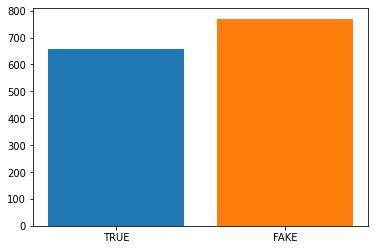

In [7]:
plt.bar(true_vals,len(true_vals))
plt.bar(fake_vals,len(fake_vals))
plt.show()

## Cleaning the dataset and formatting the labels

In [8]:
df = df.dropna()

In [9]:
labels = df.authenticity
convert = lambda x : 0 if x == 'FAKE' else 1
labels = [convert(label) for label in labels ]
count=0
for label in labels:
    if label == 1:
        count = count + 1

## Computing the wordcloud

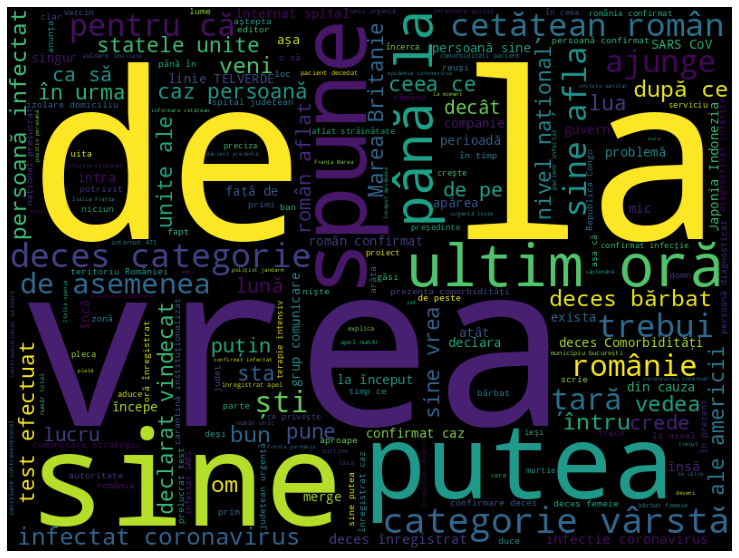

In [10]:
wordcloud = WordCloud(background_color='black', width=800, height=600)
wordcloud = wordcloud.generate(' '.join(df['preprocessed body']))

plt.figure(figsize=(15,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()


## Splitting the dataset 

In [11]:
X_train, X_val, y_train, y_val = train_test_split(df['preprocessed body'] ,labels, test_size = 0.2, random_state=6)

# Building the model

### Tokenizer

In [12]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
voc_size = len(tokenizer.word_index) + 1
print('Vocabulary size: {}'.format(voc_size))

Vocabulary size: 12845


In [13]:
X_train = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen = 256)
X_val = pad_sequences(tokenizer.texts_to_sequences(X_val), maxlen=256)

print('Shape of train: {}'.format(X_train.shape))
print('Shape of validation: {}'.format(X_val.shape))

Shape of train: (1132, 256)
Shape of validation: (284, 256)


### Modeling

In [14]:
inputs = Input(shape=(256,), dtype='int32')

model = Sequential(
    [Embedding(voc_size, 25),
    Dropout(0.8),
    LSTM(256),
    Dropout(0.8),
    Dense(256, activation = 'relu'),
    Dropout(0.8),
    Dense(128, activation = 'relu'),
    Dropout(0.8),
    Dense(1,activation = 'sigmoid')]
)


model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 25)          321125    
_________________________________________________________________
dropout (Dropout)            (None, None, 25)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 256)               288768    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
________________________________________________________

In [17]:
y_val = np.array(y_val)
y_train = np.array(y_train)

In [16]:
model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs=10, batch_size=32)

Train on 1132 samples, validate on 284 samples
Epoch 1/10
1132/1132 [==============================] - 13s 12ms/sample - loss: 0.7084 - acc: 0.5159 - val_loss: 0.6907 - val_acc: 0.5423
Epoch 2/10
1132/1132 [==============================] - 13s 11ms/sample - loss: 0.6911 - acc: 0.5300 - val_loss: 0.6897 - val_acc: 0.5423
Epoch 3/10
1132/1132 [==============================] - 13s 11ms/sample - loss: 0.6937 - acc: 0.5336 - val_loss: 0.6885 - val_acc: 0.5423
Epoch 4/10
1132/1132 [==============================] - 13s 11ms/sample - loss: 0.6931 - acc: 0.5150 - val_loss: 0.6870 - val_acc: 0.5423
Epoch 5/10
1132/1132 [==============================] - 13s 11ms/sample - loss: 0.6883 - acc: 0.5433 - val_loss: 0.6831 - val_acc: 0.5423
Epoch 6/10
1132/1132 [==============================] - 13s 11ms/sample - loss: 0.6966 - acc: 0.5574 - val_loss: 0.6835 - val_acc: 0.7641
Epoch 7/10
1132/1132 [==============================] - 13s 11ms/sample - loss: 0.7128 - acc: 0.5901 - val_loss: 0.6156 - val

In [ ]:
model.save('model92.h5')

In [14]:
new_model = tf.keras.models.load_model('model92.h5')

In [15]:
test_data = ['om sine trece câine dietă vegană transforma pericol public umbla stradă legumă vedere dimineață câine vegan scăpat lesă sine înfige colț castravete bărbat an bărbat rămâne tzatziki salată asortat murătură castravete amenința proprietar animal vrea judecată groaznic veni piață procura castravete fabio centimetru scop consuma odată ajuns acasă explica jean victimă atac intra bloc vedea fiară rupe lesă goni sine înfige colț castravete rămâne decât codiță cădea picior turti roșu cetățean plăcea sine plimba parc fleică mânzat borsetă spune conveni trend câine vegani spera fiță trecător','lider PNL USR UDMR semna marți seară coaliție guvernare criză politic izbucnite demitere premier florin cîțu PNL ministru sănătate vlad voiculescu USR anunța vrea propune ministru sănătate','Regina elisabeta nevoit sta singur funeralii restricție impus pandemie coronavirus cameră filmare putea capta expresie chip regină sta cap plecat membru casă regal apărea imagine față întristat prinț edward mic copil regină prinț philip văzut pune sine mână frunte cor intona imn religios văzut fixa distanță sicriu tată membru casă regal special invitat purta haină doliu culoare închis mască sanitar negru păstra distanță celălalt așezare scaun interior capelă George respecta restricție impus pandemie coronavirus']

In [16]:
label = ['0','1','1']

In [17]:
test_data = ['așteptat reuniune diplomatic klaus Iohannis Maia sandu presărat gafă precădere parte moldovenesc martor spune maia sandu căuta inițial Iohannis bucurești deși constituție capital României încă Predeal rău ajunge pârtie prezidențial lidera chișinău îmbrăcat subțire schi dezamăgit putea ataca pârtie diplomatic oră sine aglomera ocazie bun cadou doamnă Maia niște schi însemn românie probabil mic eroare comunicare mână PSD declara Iohannis persoană înalt costum schi sine ști sigur fiindcă purta ochelari mască maia sandu sine cere scuză gafă protocol promite următor întâlnire vrea veni pregătit schi săniuță sac celofan capac WC',
            'românia confirmat infectare coronavirus total românia muri persoană infectat coronavirus caz coronavirus confirmat teritoriu țară anunțat februarie autoritate apel populație sine informa sursă oficial',
            'alianță unire român aur anunța marți întru comunicat presă sine alătura formațiune politic membru USR raluca amariei dan rădulescu lider uniune salva românia USR aripă conservator formațiune adera alianță unire român aur amariei rădulescu demisiona USR urmare diferență accentuat viziune orientare doctrinar decide sine alătura alianță unire român singur partid sine fundamenta activitate valoare familie națiune credință libertate sine arăta comunicat transmis aur accepta invitație copreședinte George simion claudiu târziu participa construcție îndrăzneț mulțumi încredere arăta alianță unire român ajunge parlament an trecut fond vot protest șansă demonstra alternativă credibil serios politic românesc dori alianță unire român opțiune vot român singur formațiune merita șansă moment transmite raluca amariei membră USR încă demisie USR asigura alegător vrea continua luptă politic începe vrea milita sistem învățământ incluziv performant constituțional mediu sănătos princip conservator sine regăsi valoare definitoriu aur pas firesc singur zonă politic românesc punct cardinal familie națiune credință libertate spune dan rădulescu vrea coordona departament politică public filială aur prahova opțiune lider USR viziune creștin conservator singular consilier local bucurești pleca USR intra aur vară an lider consiliere sector membru fondator USB USR Antonio andrușceac deputat aur Bacău sine preciza comunicat transmis aur'
            ]

In [18]:
label = ['0','1','1']

In [19]:
X_test, _, y_test, _ = train_test_split(pd.DataFrame(np.array(test_data)) ,pd.DataFrame(np.array(label)),test_size = 1 )

In [20]:
chosen_articles = X_test.to_numpy()

In [21]:
text_series = X_test.squeeze()
label_series = y_test.squeeze()

In [22]:
X_test = pad_sequences(tokenizer.texts_to_sequences(text_series))
y_test = pad_sequences(tokenizer.texts_to_sequences(label_series))

In [23]:
X_test = np.array(X_test)
y_test = np.array(y_test)

In [24]:
X_test = pad_sequences(tokenizer.texts_to_sequences(text_series))
y_test = pad_sequences(tokenizer.texts_to_sequences(label_series))

In [25]:
predictions = new_model.predict(X_test,batch_size=1)

In [26]:
CATEGORIES = ['TRUE','FAKE']

In [27]:
for index,prediction in enumerate(predictions):
    print(chosen_articles[index])
    answer = lambda x : 'TRUE' if int(round(x))==1 else 'FALSE' 
    print(f'{answer(prediction[0])}, percentage = {prediction[0]}')

['alianță unire român aur anunța marți întru comunicat presă sine alătura formațiune politic membru USR raluca amariei dan rădulescu lider uniune salva românia USR aripă conservator formațiune adera alianță unire român aur amariei rădulescu demisiona USR urmare diferență accentuat viziune orientare doctrinar decide sine alătura alianță unire român singur partid sine fundamenta activitate valoare familie națiune credință libertate sine arăta comunicat transmis aur accepta invitație copreședinte George simion claudiu târziu participa construcție îndrăzneț mulțumi încredere arăta alianță unire român ajunge parlament an trecut fond vot protest șansă demonstra alternativă credibil serios politic românesc dori alianță unire român opțiune vot român singur formațiune merita șansă moment transmite raluca amariei membră USR încă demisie USR asigura alegător vrea continua luptă politic începe vrea milita sistem învățământ incluziv performant constituțional mediu sănătos princip conservator sine r